# Material Identification

## Acknowledgements

I would like to give credit to Madjek, Inc. in Amityville, NY who provided the facilities for data collection and helped to advise in the business case scenario for this project. Although this scenario is a fictitious one, they were still happy to serve as an example for this data investigation, and we thank them for their support.

## Objective

To develop a Covolutional Nueral Network that can properly identify material types for warehouse and scrap material handling.

## Business Problem

Our client Madjek, Inc. is a store fixture manufacturer who purchases a variety of sheet good materials for different jobs. They would like to install a material handling system which would keep track of their sheet good products in their warehouse.+ For the installation of this system, they would also like to eliminate barcodes and barcode scanners that would typically be used to track materials, so as to reduce the amount of employees required for material handling, as well as reduce human error in handling. In order to do this, they will need to have a system in place (using cameras and scanners) which would automatically recognize the type of material in a given situation. The system would need to recognize the material at certain intervals in material handling:

- When the material is offloaded from a truck and placed into the warehouse
- When the material is cut on the panel saw and then stored in with scrap cuts in the warehouse
- To serve as a quality control check at the CNC routers to confirm the correct material has been placed on the machine

The company has 4 main types of materials that they work with that they would like to have classified:

- MDF
- TFL / Particle Core with HPL
- Particle Core
- Veneer Core


Ultimately our client would like the model to be as accurate as possible. They are looking for a accuracy rating that falls within six sigma standards, which ideally refers to a 99.999997% accuracy. This computer vision system is intended to be integrated into an automated material and inventory handling system, so any time a material is identified incorrectly, it has the strong possibility of being cut and sent out with the wrong material for production. Given this, there is no preference on whether the material identified is a false positive or a false negative, only that it cannot be false at all. 

The client also understands that achieving this ultimate goal will take iterations of the system in order to achieve the six sigma goal they are looking for. So for the first iteration of the system they intend to have workers at each identification interval to check the system for the first 90 days in production. Therefore, the first iteration of the computer vision network does not have to meet the six sigma goal but must attempt to get closer to that goal. We have agreed with the client to set a 70% accuracy rating goal for this iteration.

## The Dataset

The images in this dataset contains around 2000 images that were taken at varying view points in both the warehouse and the scrap racks. All images were taken on a Iphone 13 pro camera. Across the range of images, there are a variety of lighting conditions, as well as a variety of close up and far away images. The far away images were taken within the warehouse, and are used to identify an entire stack of material, where the material will be the same for the entire stack. The close up images vary for both the warehouse and the scrap racks, where the piece of material that is centered in the image is what is identified as the material type. 



Given the variation in the data, the standards that our client is shooting for are ha

All original images in the dataset are located in images/0_Madjek_NoClass. There are other folders in images which were part of preprocessing, please see the chart below for more information on each folder step
There is also a Data_image_target csv file, which contains a column for the image file name, and a column for the material type of the image.

| Folder Name  |  Description |
|---|---|
| 0_Madjek_NoClass  | Original images  |
| 1A_Madjek_Class  | Images sorted into folder hierarchy by class  |
| 1B_Madjek  | Images sorted into folder hierarchy by class and train, validation, and test sets  |
|  2A_Madjek_NoClass_Crop | Cropped images  |
| 2B_Madjek_Class_Crop  |  Cropped images sorted into folder hierarchy by class  |
| 2C_Madjek_Crop  |  Cropped images sorted into folder hierarchy by class and train, validation, and test sets |

Under the images folder, each folder has an initial number and letter where the number represents the iteration of preprocessed images and the letter represents the substage of the processing of those images. The original 0_Madjek_NoClass folder contains all of the original images for the project. A separate notebook named "Crop Images" was created in order to crop all original images and store the images in a new folder called "Madjek_Crop." Another notebook named "Train-Split-Multiclass-Images" was created to use the csv file to organize the images into subfolders by class (which were stored in the "Madjek_Class" folders) and then subsequently break the images into train, test, and validation sets (which were stored in the "Madjek" folders).

## Modeling

Our models included 3 base models, 2 regularized models, and 2 transfer learning models. Of all the CNN's we created, our last transfer learning model seemed to give the best results. This model is a Resnet50V2 model with data augmentation, dropout, and rescaling.

This model has a softmax activation function at the end and uses an adam optimizer for compiling.



## Reading and Analyzing the Data

We will start by importing the libraries required for the notebook and pulling in the data:

In [81]:
# import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(rc={'savefig.dpi':300, 'figure.figsize':(12,8)})
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
import cv2
import argparse
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import datetime

In [82]:
# load the tensorboard notebook extension
%load_ext tensorboard

In [83]:
# Clear any tensorboard logs from previous runs
rm -rf ./logs/

SyntaxError: invalid syntax (<ipython-input-83-00325e218c3e>, line 2)

Lets take a look at some of the image files to get a better idea of the data we are working with.

In [2]:
# Create a function to show specified image files within a directory
def imgfileshow(filenames, directory, cols, rows):
    imgs = []
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,12))
    for count, IM in enumerate(filenames):
        img = image.load_img((directory + '/' + IM), target_size=None)
        ax = axes[count//cols][count%cols]
        ax.imshow(img)
        ax.grid(False)
        imgs.append(img)

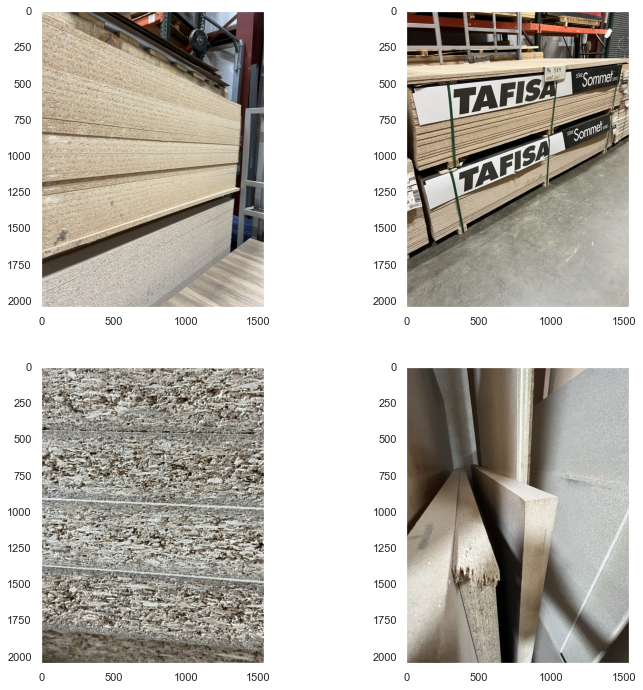

In [3]:
# Images selected to load
IMGtoLoad = ['IMG_1114.jpeg', 'IMG_1125.jpeg', 'IMG_1583.jpeg', 'IMG_1743.jpeg']

# Run function to show selected images in a 2 x 2 grid
imgfileshow(IMGtoLoad, f'images/0_Madjek_NoClass', 2, 2)

We have a couple problems in these images that we will have to deal with. 

- The images are large (1536 x 2048), we will need to scale them down in order to reduce the modeling time
- Some images contain one piece of material and others contain a stack of material. By looking at the corresponding labels for the images, it looks like the material at the center of the image is what is being identified. We will need to crop the images to only include the center area of the image for proper identification
- Some images are close up and some images are taken far away. Not sure how we will deal with this, but will have to come back to it.



Lets take a look at the proportions of each of the classes we have in the csv file

In [4]:
# Load csv data into pandas dataframe and show
df_target = pd.read_csv('images/Data_Image_Target.csv')
df_target

,IMG,Mat
0,IMG_1089,PC
1,IMG_1090,PC
2,IMG_1091,PC
3,IMG_1092,PC
4,IMG_1093,PC
...,...,...
2056,IMG_3148,TFL
2057,IMG_3149,TFL
2058,IMG_3150,TFL
2059,IMG_3151,TFL


In [5]:
# Show number of values in each class
print(df_target["Mat"].value_counts())

TFL    825
PC     619
MDF    309
VC     308
Name: Mat, dtype: int64


In [6]:
# Calculate percentages for each class
Value_counts = df_target["Mat"].value_counts(normalize=True)*100
Vcts = [round(item, 2) for item in list(Value_counts.to_dict().values())]
Vcts

[40.03, 30.03, 14.99, 14.94]

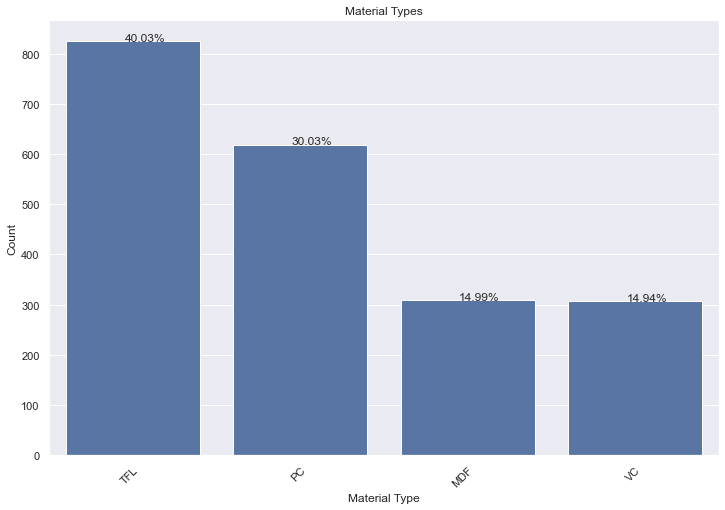

In [7]:
# Plot class types and percentages in barplot

Mat_type = df_target['Mat'].value_counts(sort=True)
Value_counts = df_target["Mat"].value_counts(normalize=True)*100
vctsdict = Value_counts.to_numpy()

ax = sns.barplot(x=Mat_type.index, y=Mat_type.values, color='b')
ax.set(xlabel="Material Type", ylabel="Count", title="Material Types")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")

for val, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate((str(Vcts[val]) + '%'), (x, y), size = 12)

The TFL class seems to have the most amount of data points at 40% of the entire dataset, with PC coming in second at 30% and MDF and VC coming in at 15%. So it seems that we have a slight class imbalance between them all. We may want to implement some techniques that will reduce the issues of this imbalance in the dataset.

## Preprocessing Data

### Check for nulls and total count

Lets just double check the target data for any nulls or problems in that set before moving forward.

In [8]:
# check csv file for any nulls
df_target.isnull().sum()

IMG    0
Mat    0
dtype: int64

In [9]:
# Show description on csv file data
df_target.describe()

,IMG,Mat
count,2061,2061
unique,2061,4
top,IMG_2013,TFL
freq,1,825


In [10]:
# get total number of files in original folder to confirm count matches to csv file
dir_path = r'C:\Users\Tim\Documents\Flatiron\Phase_4\Material-Identification\images\0_Madjek_NoClass'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 2061


There are no nulls in the csv file and the count of images matches the count of rows in the csv file. 

### Sample crop and resize

We will start by cropping the sample images that we pulled from the dataset as reference to how we intend to crop the images. The intention behind cropping is not to focus on the image size itself, but to crop it enough so as to focus on only the center of each image. Even in the sample images that we pulled, there are multiple materials showing due to the materials being stacked close to one another. We want to generally only have the material that is in the center of the image within the frame of the image.

In [11]:
# Converts the image file into a tensor
sam_imgs = [tf.io.decode_image((tf.io.read_file(f'images/0_Madjek_NoClass/{IM}')), channels=3, dtype=tf.dtypes.float32) for IM in IMGtoLoad]

In [12]:
# Crop the sample images using a pre determined crop ratio
crpimgs = tf.image.central_crop(sam_imgs, 0.4)

In [13]:
# Create a function to show tensor images

def tensorimgshow(filenames, cols, rows):
    imgs = []
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,12))
    for count, IM in enumerate(filenames):
        img = image.array_to_img(IM)
        ax = axes[count//cols][count%cols]
        ax.imshow(img)
        ax.grid(False)
        imgs.append(img)

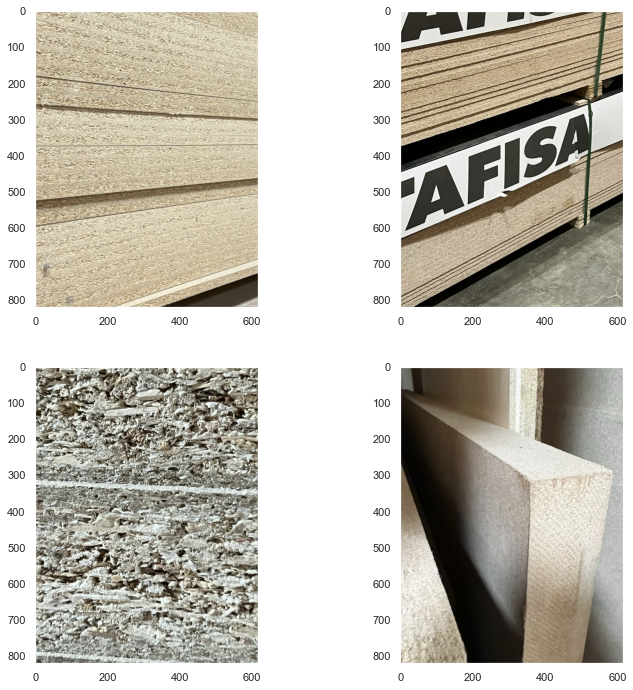

In [14]:
# Run function to show cropped images
tensorimgshow(crpimgs, 2, 2)

IN order to futher improve processing time, we will also resize the dpi for the images

In [15]:
img_height = 256
img_width = 192

In [16]:
crpsizeimgs = tf.image.resize(crpimgs, [img_height, img_width])

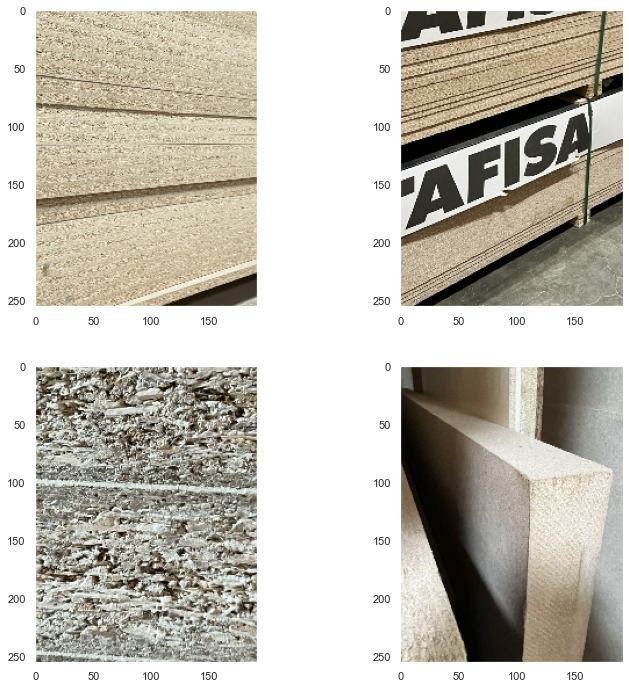

In [17]:
tensorimgshow(crpsizeimgs, 2, 2)

### Balance classes

Last but not least, we do have a slight class imbalance in the dataset, so we will want to adjust the data for this. We are going to calculate the weight for each class and use that as one of our baseline models to see how it does.

In [18]:
total = len(df_target)

In [19]:
Class_total = list(df_target["Mat"].value_counts())

In [20]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / Class_total[0]) * (total / 4.0)
weight_for_1 = (1 / Class_total[1]) * (total / 4.0)
weight_for_2 = (1 / Class_total[2]) * (total / 4.0)
weight_for_3 = (1 / Class_total[3]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 0.62
Weight for class 1: 0.83
Weight for class 2: 1.67
Weight for class 3: 1.67


## Preparing the Data for Modeling

Our images have been split beforehand into separate train, test, and validation folders. One thing we will need to do is assign these images to the proper variables in order to process them through our Convolutional Neural Network.

In [21]:
batch_size =  32

In [22]:
base_model0_train_dir = "images/1B_Madjek/train/"
base_model0_test_dir = "images/1B_Madjek/test/"
base_model0_val_dir = "images/1B_Madjek/val/"

In [23]:
# transfer data from directories to batches

base_model0_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_train_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model0_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_test_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model0_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model0_val_dir,                                               
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

Found 1648 files belonging to 4 classes.
Found 210 files belonging to 4 classes.
Found 203 files belonging to 4 classes.


In [24]:
for image_batch, labels_batch in base_model0_train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 192, 3)
(32, 4)


In [25]:
classes=list(base_model0_train_data.class_names)
num_classes=len(classes)
num_classes

4

In [26]:
classes

['MDF', 'PC', 'TFL', 'VC']

## Baseline CNNs

### Base Model 0

In [27]:
# Create baseline model
base_model0 = models.Sequential()

# Add the appropriate layers
base_model0.add(layers.experimental.preprocessing.Rescaling(1./255))
base_model0.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_height, img_width, 3)))
base_model0.add(layers.MaxPooling2D(2, 2))

base_model0.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model0.add(layers.MaxPooling2D(2, 2))

base_model0.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model0.add(layers.MaxPooling2D(2, 2))

base_model0.add(layers.Flatten())
base_model0.add(layers.Dense(64, activation='relu'))
base_model0.add(layers.Dense(num_classes, activation='softmax'))



In [28]:
# Compile the model
base_model0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer="adam",
              metrics=['accuracy'])

In [29]:
# Return a summary of our model
base_model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 95, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 92, 32)       16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 42240)             0

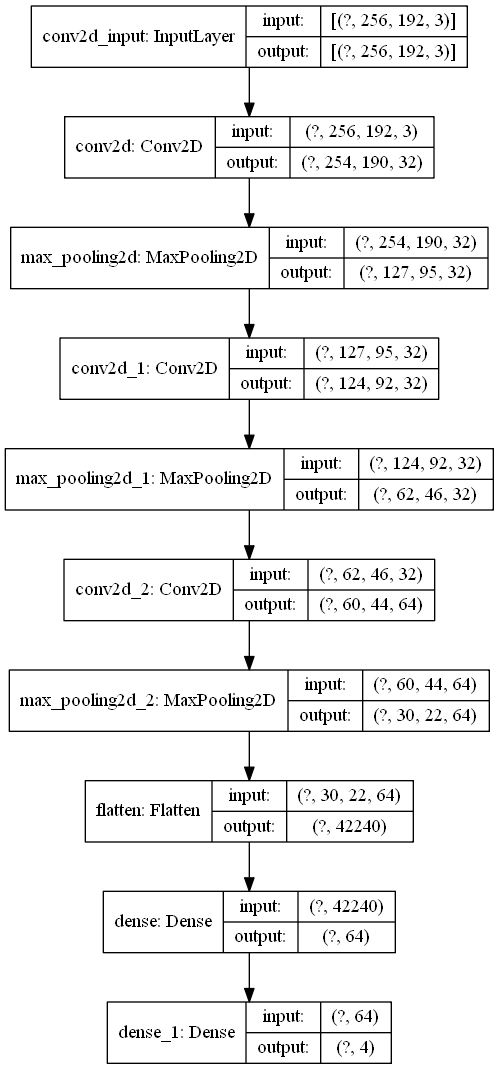

In [30]:
# Return image of model's architecture
plot_model(base_model0, show_shapes=True, show_layer_names=True)

In [31]:
epochs=20
bm0_history = base_model0.fit(
  base_model0_train_data,
  validation_data=base_model0_val_data,
  epochs=epochs
)

Epoch 1/20
52/52 [==============================] - 69s 1s/step - loss: 52.7576 - accuracy: 0.3404 - val_loss: 1.3423 - val_accuracy: 0.4384
Epoch 2/20
52/52 [==============================] - 65s 1s/step - loss: 1.2467 - accuracy: 0.4654 - val_loss: 1.3378 - val_accuracy: 0.4236
Epoch 3/20
52/52 [==============================] - 67s 1s/step - loss: 1.0247 - accuracy: 0.5807 - val_loss: 1.4918 - val_accuracy: 0.3941
Epoch 4/20
52/52 [==============================] - 65s 1s/step - loss: 0.7956 - accuracy: 0.6851 - val_loss: 1.7033 - val_accuracy: 0.4483
Epoch 5/20
52/52 [==============================] - 63s 1s/step - loss: 0.6147 - accuracy: 0.7567 - val_loss: 1.9628 - val_accuracy: 0.4729
Epoch 6/20
52/52 [==============================] - 63s 1s/step - loss: 0.4777 - accuracy: 0.8143 - val_loss: 2.2704 - val_accuracy: 0.4483
Epoch 7/20
52/52 [==============================] - 63s 1s/step - loss: 0.3591 - accuracy: 0.8623 - val_loss: 2.6159 - val_accuracy: 0.4384
Epoch 8/20
52/52 [=

In [32]:
base_model0.evaluate(base_model0_test_data)

7/7 [==============================] - 1s 134ms/step - loss: 7.8876 - accuracy: 0.3476


[7.887638568878174, 0.34761905670166016]

In [33]:
def show_classification_report_and_confusion_matrix(model, batchDataset_test_data, classes, cmap, cm_title):
    y_pred_array = model.predict(batchDataset_test_data)
    y_pred = np.argmax(y_pred_array, axis = 1)
    y_test_array = tf.concat([y for x, y in batchDataset_test_data], axis = 0).numpy() # convert to np array
    y_test = np.argmax(y_test_array, axis = 1)
    print(classification_report(y_test, y_pred, target_names=classes))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap = cmap)
    disp.ax_.set_title(cm_title)
    plt.grid(False)
    plt.show()

              precision    recall  f1-score   support

         MDF       0.14      0.12      0.13        32
          PC       0.19      0.16      0.17        63
         TFL       0.38      0.43      0.41        83
          VC       0.06      0.06      0.06        32

    accuracy                           0.25       210
   macro avg       0.19      0.19      0.19       210
weighted avg       0.24      0.25      0.24       210



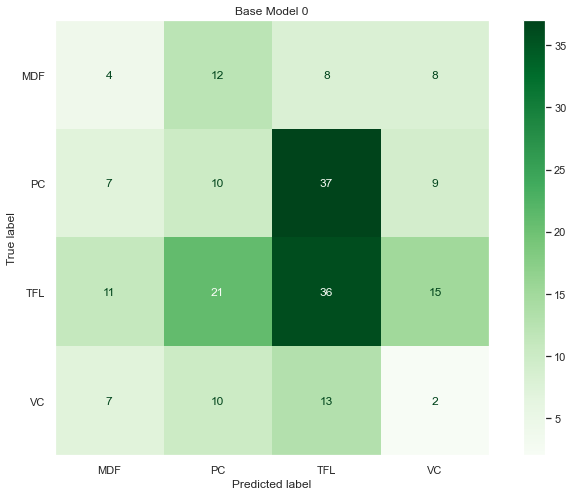

In [34]:
show_classification_report_and_confusion_matrix(base_model0, base_model0_test_data, classes, "Greens", "Base Model 0")

In [35]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

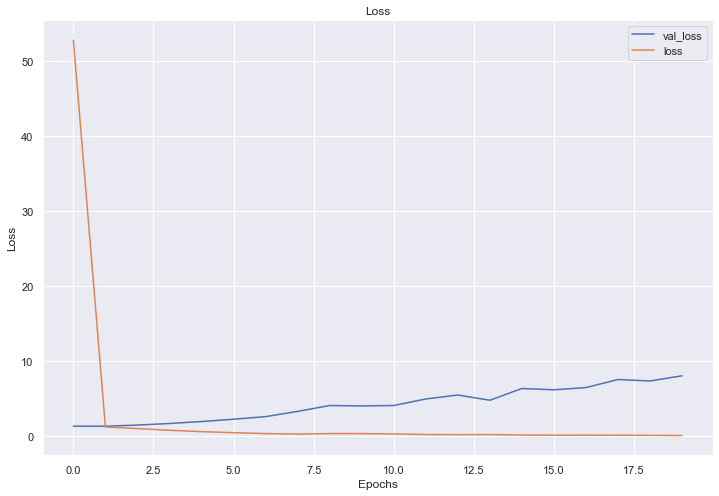

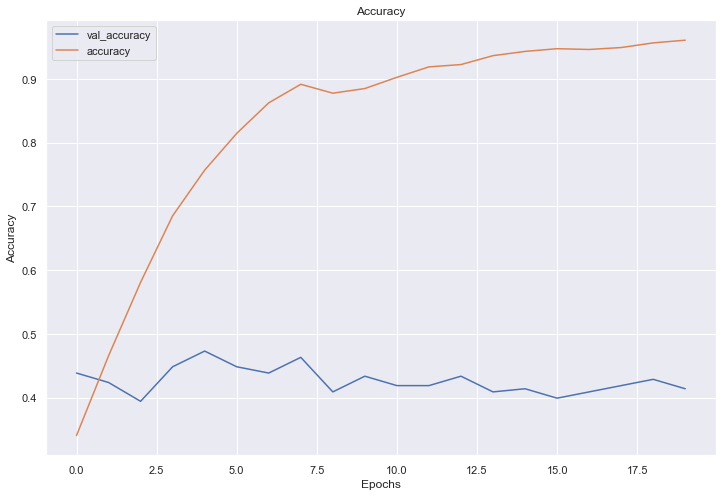

In [36]:
visualize_training_results(bm0_history)

Our accuracy increases but our validation accuracy stays about the same. It is concerning that after the first epoch, the train loss decreases and the validation loss increases. We will need to find a way to remedy that.

### Base Model 1

After cropping we looked through each of the images individually confirm that they showed the material that was identified originally. Photos were deleted from the set that had:
- More than one material in the image frame
- an material which did not match the true label
- did not show the edge of the material, which is requiired for identification

Images removed were the following:

In [37]:
imgs_removed = ['IMG_2809', 'IMG_2810', 'IMG_1832', 'IMG_1833', 'IMG_2005', 'IMG_2049', 'IMG_2386', 
                'IMG_2415', 'IMG_2529', 'IMG_2532', 'IMG_2535', 'IMG_2536', 'IMG_2537', 'IMG_1480', 
                'IMG_1486', 'IMG_1487', 'IMG_1488', 'IMG_1489', 'IMG_1490', 'IMG_1491', 'IMG_1492', 
                'IMG_1493', 'IMG_1536', 'IMG_1537', 'IMG_1538', 'IMG_1542', 'IMG_1795', 'IMG_1796', 
                'IMG_1814', 'IMG_1904', 'IMG_2204', 'IMG_2249', 'IMG_2550', 'IMG_2573', 'IMG_1609',
                'IMG_1650', 'IMG_1694', 'IMG_1713', 'IMG_1829', 'IMG_2088', 'IMG_2417', 'IMG_2548', 
                'IMG_2610', 'IMG_2817', 'IMG_2826']

In [38]:
base_model1_train_dir = "images/2C_Madjek_Crop/train/"
base_model1_test_dir = "images/2C_Madjek_Crop/test/"
base_model1_val_dir = "images/2C_Madjek_Crop/val/"

In [39]:
# transfer data from directories to batches

base_model1_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_train_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model1_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_test_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

base_model1_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_model1_val_dir,                                               
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

Found 1609 files belonging to 4 classes.
Found 206 files belonging to 4 classes.
Found 199 files belonging to 4 classes.


For our future models we will also apply rescaling to standardize all of the images to improve the gradient descent of our models.

In [40]:
# Create baseline model
base_model1 = models.Sequential()

# Add the appropriate layers
base_model1.add(layers.experimental.preprocessing.Rescaling(1./255))
base_model1.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', 
                        input_shape=(img_height, img_width, 3)))
base_model1.add(layers.MaxPooling2D(2, 2))

base_model1.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model1.add(layers.MaxPooling2D(2, 2))

base_model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model1.add(layers.MaxPooling2D(2, 2))

base_model1.add(layers.Flatten())
base_model1.add(layers.Dense(64, activation='relu'))
base_model1.add(layers.Dense(num_classes, activation='softmax'))



In [41]:
# Compile the model
base_model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer="adam",
              metrics=['accuracy'])

In [42]:
bm1_history = base_model1.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs
)

Epoch 1/20
51/51 [==============================] - 41s 808ms/step - loss: 1.2484 - accuracy: 0.3785 - val_loss: 1.1851 - val_accuracy: 0.4171
Epoch 2/20
51/51 [==============================] - 40s 786ms/step - loss: 1.1903 - accuracy: 0.4357 - val_loss: 1.1518 - val_accuracy: 0.4724
Epoch 3/20
51/51 [==============================] - 40s 787ms/step - loss: 1.0779 - accuracy: 0.5003 - val_loss: 1.0790 - val_accuracy: 0.5226
Epoch 4/20
51/51 [==============================] - 40s 783ms/step - loss: 0.9532 - accuracy: 0.5873 - val_loss: 1.0917 - val_accuracy: 0.5075
Epoch 5/20
51/51 [==============================] - 40s 779ms/step - loss: 0.8227 - accuracy: 0.6513 - val_loss: 1.1286 - val_accuracy: 0.4975
Epoch 6/20
51/51 [==============================] - 40s 780ms/step - loss: 0.6518 - accuracy: 0.7489 - val_loss: 1.3201 - val_accuracy: 0.4975
Epoch 7/20
51/51 [==============================] - 40s 786ms/step - loss: 0.4967 - accuracy: 0.8111 - val_loss: 1.4549 - val_accuracy: 0.4472

In [43]:
base_model1.evaluate(base_model1_test_data)

7/7 [==============================] - 1s 132ms/step - loss: 4.3104 - accuracy: 0.4223


[4.310384273529053, 0.4223301112651825]

              precision    recall  f1-score   support

         MDF       0.25      0.12      0.17        32
          PC       0.32      0.31      0.31        62
         TFL       0.42      0.52      0.46        81
          VC       0.17      0.16      0.17        31

    accuracy                           0.34       206
   macro avg       0.29      0.28      0.28       206
weighted avg       0.32      0.34      0.33       206



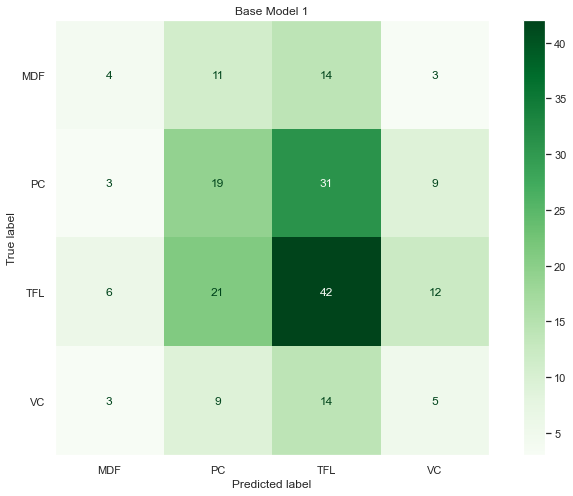

In [44]:
show_classification_report_and_confusion_matrix(base_model1, base_model1_test_data, classes, "Greens", "Base Model 1")

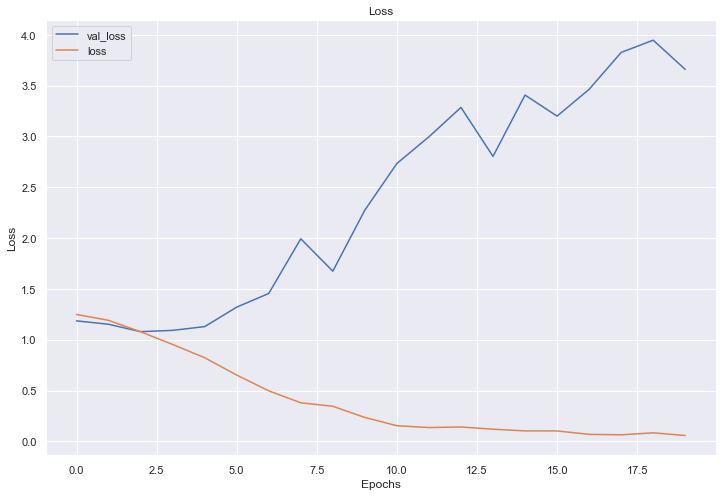

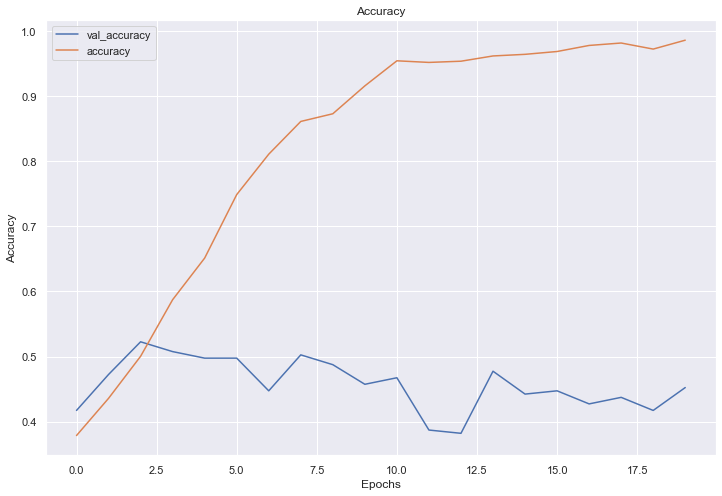

In [45]:
visualize_training_results(bm1_history)

Looks like we received similar results in this base model in comparison to the last one. But in this one, we received slightly better results for the validation accuracy by around 8% and a better validation loss as well. The test accuracy is a hair lower in this model, but it seems overall that Base model 1 performed better than the original base model. So we will move forward with base model 1 in our future models.

## CNN regularization model with Standardized data, Data Augmentation and Dropout

One of the largest problems we have had in all of the base models is overfitting. The train data quickly overfits and provides terrible results for both validation and test accuracy. The next model we will create will be a model that integrates dropout layers at the end so as to regularize the data and prevent such heavy overfitting.

Also, considering that we are attempting to solve a image classification problem, we will integrate some preprocessing layers into the following model. A rescaling layer in order to normalize the values in the data, and data augmentation layers which will augment the data in an effort to introduce a similar variety to the train data to improve performance.

Lastly, when fitting we will make sure to include the class weights that we had calculated in the data preprocessing so as to offset the class imbalance that exists in the dataset currently.

In [77]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [78]:
# Set up early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
lr_redox = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, lr_redox, tensorboard_callback]

### Reg Model 0

In [79]:

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Create regularized model with dropout
reg_model0 = models.Sequential([data_augmentation])

# Add the appropriate layers
reg_model0.add(layers.experimental.preprocessing.Rescaling(1./255))
reg_model0.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                        input_shape=(img_height, img_width, 3)))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model0.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model0.add(layers.Flatten())
reg_model0.add(layers.Dense(512, activation='relu'))
reg_model0.add(layers.Dropout(0.3))
reg_model0.add(layers.Dense(512, activation='relu'))
reg_model0.add(layers.Dropout(0.3))
reg_model0.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
reg_model0.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [86]:
rm0_history = reg_model0.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=callbacks
)

Epoch 1/50
51/51 [==============================] - 44s 869ms/step - loss: 1.3596 - accuracy: 0.4220 - val_loss: 1.3597 - val_accuracy: 0.4221
Epoch 2/50
51/51 [==============================] - 46s 895ms/step - loss: 1.3467 - accuracy: 0.4276 - val_loss: 1.2544 - val_accuracy: 0.4372
Epoch 3/50
51/51 [==============================] - 44s 863ms/step - loss: 1.3329 - accuracy: 0.4295 - val_loss: 1.2494 - val_accuracy: 0.4271
Epoch 4/50
51/51 [==============================] - 44s 856ms/step - loss: 1.3298 - accuracy: 0.4319 - val_loss: 1.2430 - val_accuracy: 0.4422
Epoch 5/50
51/51 [==============================] - 44s 856ms/step - loss: 1.3168 - accuracy: 0.4438 - val_loss: 1.2647 - val_accuracy: 0.4372
Epoch 6/50
51/51 [==============================] - 45s 874ms/step - loss: 1.2924 - accuracy: 0.4413 - val_loss: 1.2083 - val_accuracy: 0.4322
Epoch 7/50
51/51 [==============================] - 45s 878ms/step - loss: 1.2951 - accuracy: 0.4574 - val_loss: 1.2123 - val_accuracy: 0.4472

In [87]:
reg_model0.evaluate(base_model1_test_data)

7/7 [==============================] - 1s 146ms/step - loss: 1.2262 - accuracy: 0.4709


[1.2261614799499512, 0.47087377309799194]

              precision    recall  f1-score   support

         MDF       1.00      0.03      0.06        32
          PC       0.20      0.15      0.17        62
         TFL       0.35      0.59      0.44        81
          VC       0.09      0.06      0.07        31

    accuracy                           0.29       206
   macro avg       0.41      0.21      0.19       206
weighted avg       0.37      0.29      0.24       206



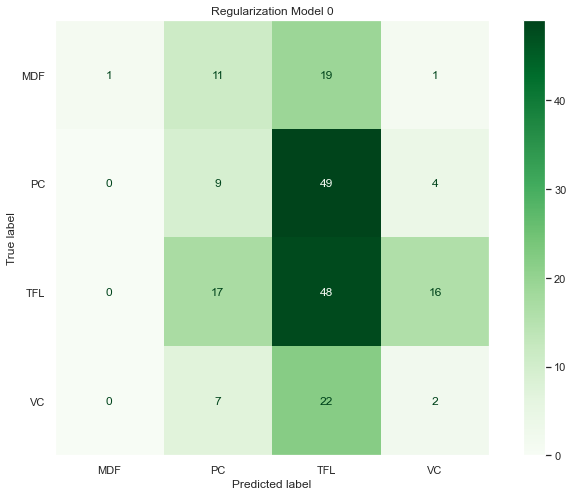

In [88]:
show_classification_report_and_confusion_matrix(reg_model0, base_model1_test_data, classes, "Greens", "Regularization Model 0")

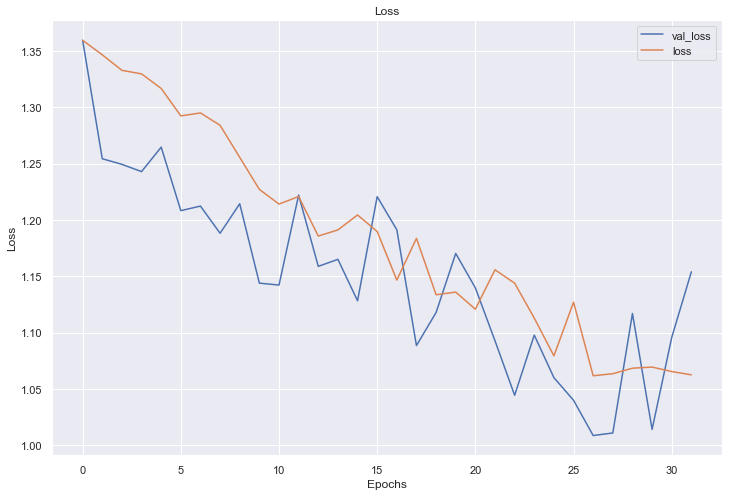

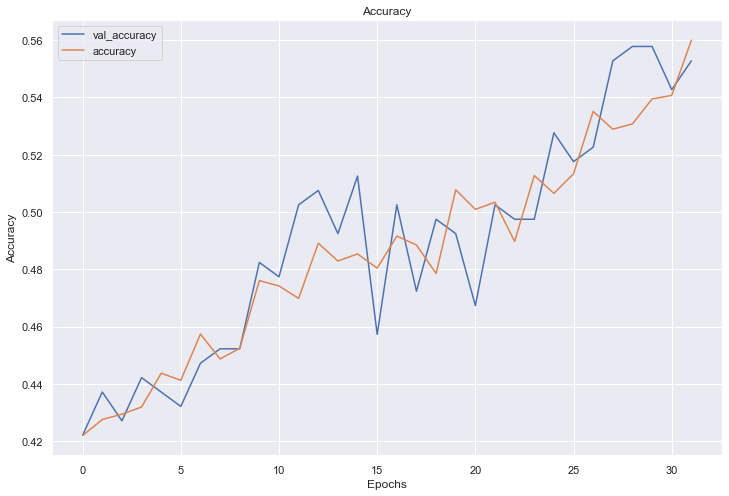

In [89]:
visualize_training_results(rm0_history)

Looks like we were able to stabilize the validation loss by applying data augmentation and dropout to the model

### Reg Model 1

Lets try and attempt to create additional dropout layers and image augmentation layers in an effort to show even more increased performance. We will also increase the epochs and add callbacks in the model to stop the model when it is required

In [90]:

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomTranslation((-0.2, 0.2), (-0.2, 0.2))
])

# Create regularized model with dropout
reg_model1 = models.Sequential([data_augmentation])

# Add the appropriate layers
reg_model1.add(layers.experimental.preprocessing.Rescaling(1./255))
reg_model1.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                        input_shape=(img_height, img_width, 3)))
reg_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model1.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
reg_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model1.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model1.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model1.add(layers.Flatten())
reg_model1.add(layers.Dense(512, activation='relu'))
reg_model1.add(layers.Dropout(0.3))
reg_model1.add(layers.Dense(512, activation='relu'))
reg_model1.add(layers.Dropout(0.3))
reg_model1.add(layers.Dense(512, activation='relu'))
reg_model1.add(layers.Dropout(0.3))
reg_model1.add(layers.Dense(512, activation='relu'))
reg_model1.add(layers.Dropout(0.3))
reg_model1.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
reg_model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [91]:
epochs = 50
rm1_history = reg_model1.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=callbacks
)

Epoch 1/50
51/51 [==============================] - 45s 876ms/step - loss: 1.5554 - accuracy: 0.3959 - val_loss: 1.3571 - val_accuracy: 0.4020
Epoch 2/50
51/51 [==============================] - 43s 839ms/step - loss: 1.4621 - accuracy: 0.3990 - val_loss: 1.2821 - val_accuracy: 0.4020
Epoch 3/50
51/51 [==============================] - 43s 837ms/step - loss: 1.4203 - accuracy: 0.4052 - val_loss: 1.2361 - val_accuracy: 0.4271
Epoch 4/50
51/51 [==============================] - 43s 840ms/step - loss: 1.4035 - accuracy: 0.4046 - val_loss: 1.3586 - val_accuracy: 0.4121
Epoch 5/50
51/51 [==============================] - 43s 838ms/step - loss: 1.3778 - accuracy: 0.4232 - val_loss: 1.3694 - val_accuracy: 0.4121
Epoch 6/50
51/51 [==============================] - 43s 835ms/step - loss: 1.4061 - accuracy: 0.4102 - val_loss: 1.2361 - val_accuracy: 0.4271
Epoch 7/50
51/51 [==============================] - 43s 836ms/step - loss: 1.3776 - accuracy: 0.4133 - val_loss: 1.3436 - val_accuracy: 0.4121

In [92]:
reg_model1.evaluate(base_model1_test_data)

7/7 [==============================] - 1s 143ms/step - loss: 1.1987 - accuracy: 0.4660


[1.198683261871338, 0.4660194218158722]

              precision    recall  f1-score   support

         MDF       0.00      0.00      0.00        32
          PC       0.31      0.18      0.22        62
         TFL       0.40      0.69      0.51        81
          VC       0.29      0.29      0.29        31

    accuracy                           0.37       206
   macro avg       0.25      0.29      0.26       206
weighted avg       0.29      0.37      0.31       206



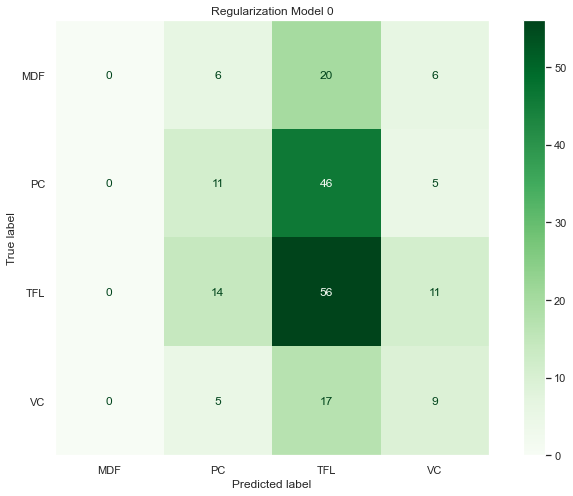

In [93]:
show_classification_report_and_confusion_matrix(reg_model1, base_model1_test_data, classes, "Greens", "Regularization Model 0")

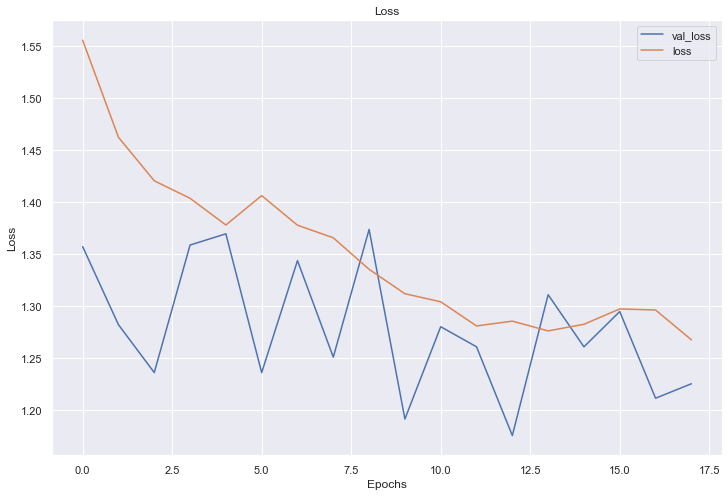

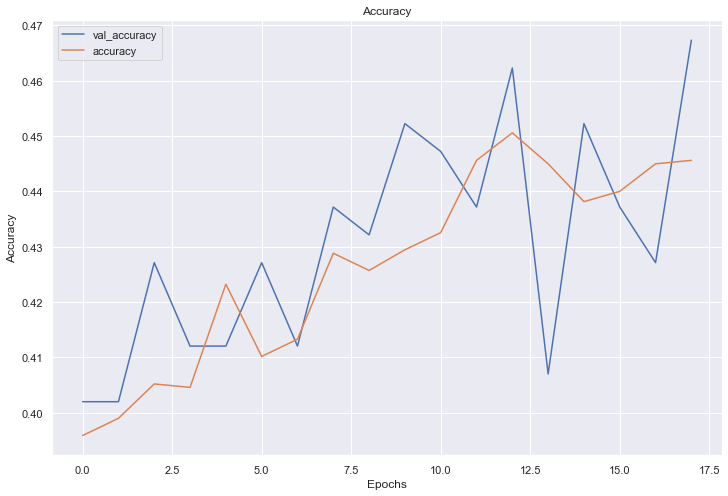

In [94]:
visualize_training_results(rm1_history)

Lets take a further look at the images that the model was able to predict correctly and what it was not able to predict correctly

In [95]:
# Create lists of correct & incorrect prediction
y_pred_array = reg_model1.predict(base_model1_test_data)
y_test_array = tf.concat([y for x, y in base_model1_test_data], axis = 0).numpy() # convert to np array

correct = np.nonzero(np.argmax(y_test_array, axis=1) == np.argmax(y_pred_array, axis=1))[0]
incorrect = np.nonzero(np.argmax(y_test_array, axis=1) != np.argmax(y_pred_array, axis=1))[0]

In [96]:
X_test_array = tf.concat([x for x, y in base_model1_test_data], axis = 0).numpy() # convert to np array

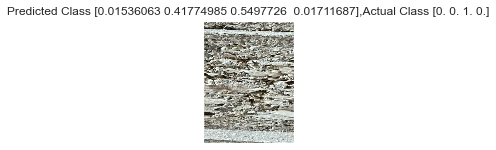

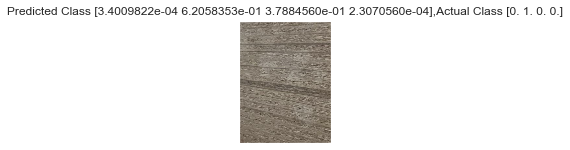

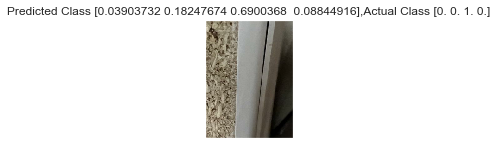

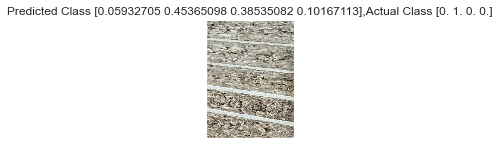

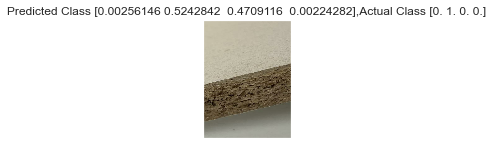

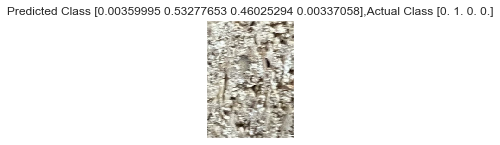

In [97]:
# Use a for loop to iterate through correct predictions,
# display the prediction values for each image and the actual class of the model
i = 0
for c in correct[:6]:
    figsize = [10, 6]
    fig, ax = plt.subplots(figsize=figsize, facecolor=(1, 1, 1))
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow((X_test_array[c]).astype(np.uint8), interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(y_pred_array[c], y_test_array[c]))
    plt.tight_layout()
    i += 1

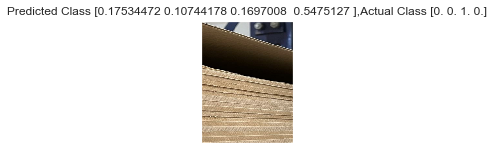

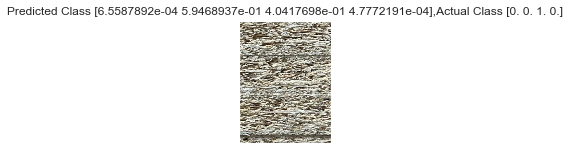

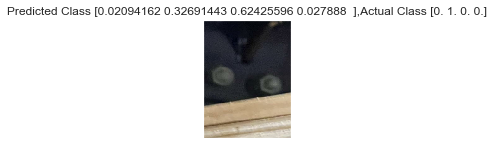

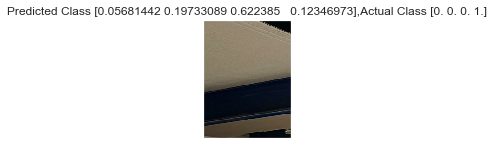

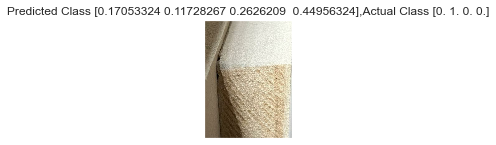

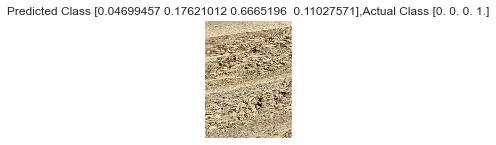

In [98]:
# Use a for loop to iterate through incorrect predictions,
# display the prediction values for each image and the actual class of the model
i = 0
for c in incorrect[:6]:
    figsize = [10, 6]
    fig, ax = plt.subplots(figsize=figsize, facecolor=(1, 1, 1))
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow((X_test_array[c]).astype(np.uint8), interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(y_pred_array[c], y_test_array[c]))
    plt.tight_layout()
    i += 1

Clearly our model's confidence in the predicted values are low. In the correctly predicted pictures, a couple of the TFL and PC predictions are very close as to which one the model intends to go with. Understandably so, considering that the only difference between the two materials is the layer of laminate on the core material itself. 

All of the incorrect predicted images have predictions which fall under 50%, and many of them have values which are very close to other class predictions. It seems that we can see a couple of issues with the incorrect images that give us insight into the problems with our curent dataset. Some TFL images have been labeled incorrectly. TFL mostly comes with a white top and bottom face, but in certain instances it can have a laminate face which is any other color, such as black, gray, and even have a wood grain printed on it.

Also, the model seems to think that cardboard in an image corresponds to the material being identified as Veneer Core. The images that were taken of veneer core typically have a a more brown tone due to the material, and also a number of the images only had a couple of sheets of veneer core with a cardboard top or bottom on it.

For all of these problems, we would need to revise the dataset to have more consistent images, as well as expand the dataset to include more instances where there are exceptions (such as with the TFL problem mentioned above)

## Transfer Learning Model 0

We could try to integrate a already trained model to see how it would perform on this complex problem.

In [99]:
from keras.applications import ResNet50V2

cnn_base = ResNet50V2(weights='imagenet', 
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

transfer_model0 = models.Sequential()
transfer_model0.add(cnn_base)
transfer_model0.add(layers.Flatten())
transfer_model0.add(layers.Dense(64, activation='relu'))
transfer_model0.add(layers.Dense(128, activation='relu'))
transfer_model0.add(layers.Dense(256, activation='relu'))
transfer_model0.add(layers.Dense(128, activation='relu'))
transfer_model0.add(layers.Dense(num_classes, activation='softmax'))

cnn_base.trainable = False


In [100]:
# Compile the model
transfer_model0.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
tm0_history = transfer_model0.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=callbacks
)

Epoch 1/50
51/51 [==============================] - 69s 1s/step - loss: 195.9455 - accuracy: 0.3468 - val_loss: 39.4022 - val_accuracy: 0.4271
Epoch 2/50
51/51 [==============================] - 68s 1s/step - loss: 24.6528 - accuracy: 0.4114 - val_loss: 13.0139 - val_accuracy: 0.4271
Epoch 3/50
51/51 [==============================] - 68s 1s/step - loss: 9.7671 - accuracy: 0.4257 - val_loss: 7.6829 - val_accuracy: 0.4221
Epoch 4/50
51/51 [==============================] - 69s 1s/step - loss: 3.9190 - accuracy: 0.3878 - val_loss: 1.3564 - val_accuracy: 0.4020
Epoch 5/50
51/51 [==============================] - 69s 1s/step - loss: 1.6195 - accuracy: 0.3996 - val_loss: 1.2966 - val_accuracy: 0.4020
Epoch 6/50
51/51 [==============================] - 69s 1s/step - loss: 1.5211 - accuracy: 0.3996 - val_loss: 1.3283 - val_accuracy: 0.4020
Epoch 7/50
51/51 [==============================] - 69s 1s/step - loss: 1.4449 - accuracy: 0.3996 - val_loss: 1.3282 - val_accuracy: 0.4020
Epoch 8/50
51/5

In [92]:
transfer_model0.evaluate(base_model1_test_data)

7/7 [==============================] - 1s 143ms/step - loss: 1.1987 - accuracy: 0.4660


[1.198683261871338, 0.4660194218158722]

              precision    recall  f1-score   support

         MDF       0.00      0.00      0.00        32
          PC       0.00      0.00      0.00        62
         TFL       0.39      1.00      0.56        81
          VC       0.00      0.00      0.00        31

    accuracy                           0.39       206
   macro avg       0.10      0.25      0.14       206
weighted avg       0.15      0.39      0.22       206



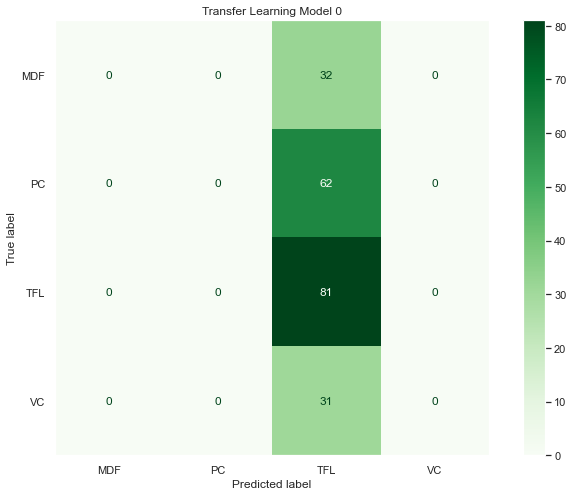

In [102]:
show_classification_report_and_confusion_matrix(transfer_model0, base_model1_test_data, classes, "Greens", "Transfer Learning Model 0")

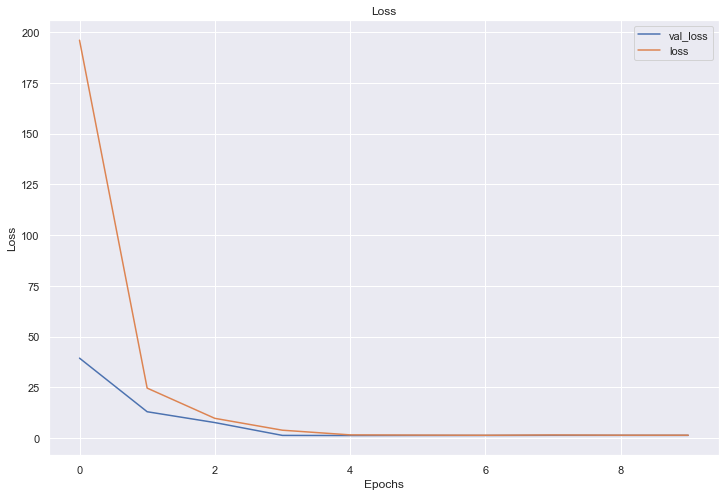

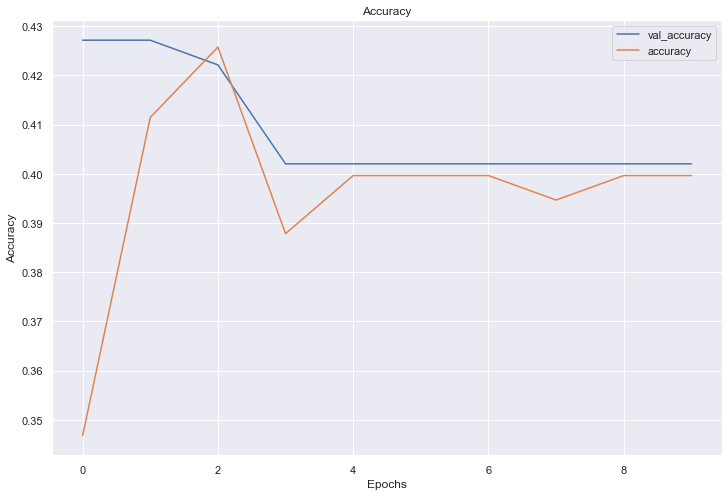

In [103]:
visualize_training_results(tm0_history)

## Transfer Learning Model 1

Lets try again with the same transfer model, but this time lets integrate the layers that improved the regularization model. So we will add the rescaling, dropout, and data augmentation layers.

In [109]:

transfer_model1 = models.Sequential([data_augmentation])
transfer_model1.add(layers.experimental.preprocessing.Rescaling(1./255))
transfer_model1.add(cnn_base)
transfer_model1.add(layers.Flatten())
transfer_model1.add(layers.Dense(64, activation='relu'))
transfer_model1.add(layers.Dense(128, activation='relu'))
transfer_model1.add(layers.Dense(256, activation='relu'))
transfer_model1.add(layers.Dense(512, activation='relu'))
transfer_model1.add(layers.Dropout(0.3))
transfer_model1.add(layers.Dense(512, activation='relu'))
transfer_model1.add(layers.Dropout(0.3))
transfer_model1.add(layers.Dense(128, activation='relu'))
transfer_model1.add(layers.Dense(num_classes, activation='softmax'))

cnn_base2.trainable = False


In [110]:
# Compile the model
transfer_model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [111]:
tm1_history = transfer_model1.fit(
  base_model1_train_data,
  validation_data=base_model1_val_data,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=callbacks
)

Epoch 1/50
51/51 [==============================] - 129s 3s/step - loss: 1.6182 - accuracy: 0.3928 - val_loss: 1.1805 - val_accuracy: 0.4774
Epoch 2/50
51/51 [==============================] - 126s 2s/step - loss: 1.2446 - accuracy: 0.4400 - val_loss: 1.0149 - val_accuracy: 0.4874
Epoch 3/50
51/51 [==============================] - 126s 2s/step - loss: 1.1198 - accuracy: 0.4829 - val_loss: 0.9716 - val_accuracy: 0.4824
Epoch 4/50
51/51 [==============================] - 128s 3s/step - loss: 1.0840 - accuracy: 0.5090 - val_loss: 0.9819 - val_accuracy: 0.5628
Epoch 5/50
51/51 [==============================] - 128s 3s/step - loss: 1.0098 - accuracy: 0.5388 - val_loss: 0.8857 - val_accuracy: 0.5427
Epoch 6/50
51/51 [==============================] - 133s 3s/step - loss: 0.9711 - accuracy: 0.5718 - val_loss: 0.8052 - val_accuracy: 0.6985
Epoch 7/50
51/51 [==============================] - 129s 3s/step - loss: 0.9435 - accuracy: 0.6128 - val_loss: 0.7559 - val_accuracy: 0.7136
Epoch 8/50
51

In [114]:
transfer_model1.evaluate(base_model1_test_data)

7/7 [==============================] - 10s 1s/step - loss: 0.7574 - accuracy: 0.6990


[0.7574355006217957, 0.6990291476249695]

              precision    recall  f1-score   support

         MDF       0.08      0.06      0.07        32
          PC       0.32      0.31      0.31        62
         TFL       0.45      0.49      0.47        81
          VC       0.22      0.23      0.22        31

    accuracy                           0.33       206
   macro avg       0.27      0.27      0.27       206
weighted avg       0.32      0.33      0.32       206



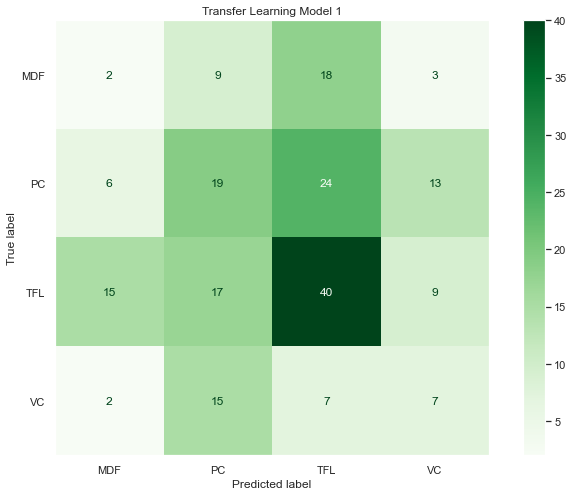

In [115]:
show_classification_report_and_confusion_matrix(transfer_model1, base_model1_test_data, classes, "Greens", "Transfer Learning Model 1")

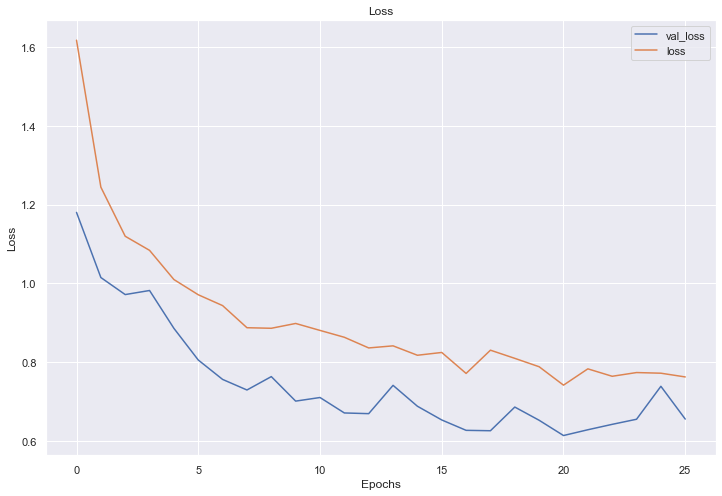

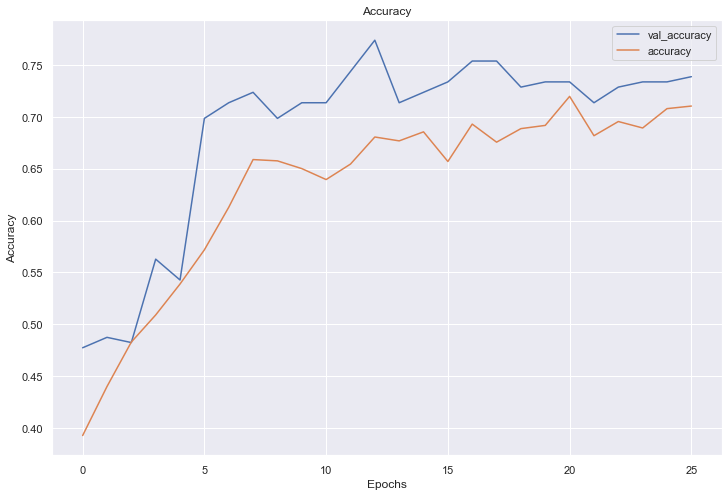

In [113]:
visualize_training_results(tm1_history)

In [116]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-02-17 12:49:12.426131: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2023-02-17 12:49:12.426259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "c:\users\tim\anaconda3\envs\learn-env\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\tim\anaconda3\envs\learn-env\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Tim\anaconda3\envs\learn-env\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "c:\users\tim\anaconda3\envs\learn-env\lib\site-packages\tensorboard\main.py", line 65, in run_main
    default.get_plugins(),
  File "c:\users\tim\anaconda3\envs\learn-env\lib\site-packages\t

## Interpretation and Evaluation

After modeling our data, our results just miss the required criteria for this exercise. 

## Recommendations

- Collect data again with additional time to create a more consistent method for obtaining quality data that is at the same distance from the object, and in the same lighting conditions. This would have to be done for each interval in the working process where an image must be taken.
- Increase the amount of data that the algorithm trains on. While 2,000 images is a good start, 10,000 or 20,000 would be even better for improving the performance of the model.
- Each working interval should a hardware setup in order to take consistent images at each interval. A dedicated area with a mounted camera and a lighting strategy should exist in (1) the warehouse for incoming skids for material, (2) at the panel saw for scrap parts, and (3) at each CNC router to confirm the material on the machine prior to cutting.

## Conclusion